# Discussing metrics and methods for evaluating ML models

In [59]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.datasets import load_breast_cancer, load_digits, load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
import warnings
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.datasets import fetch_openml
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, accuracy_score, SCORERS
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

### Plotting the confusion matrix

[[48  5]
 [ 5 85]]
0.9300699300699301


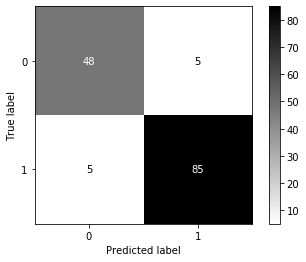

In [3]:
cancer_data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target,
                                                    stratify=cancer_data.target, random_state=0)
with warnings.catch_warnings(record=True) as w:
    lr = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(lr.score(X_test, y_test))
plot_confusion_matrix(lr, X_test, y_test, cmap='gray_r')


To illustrate why using accuracy for imbalanced datasets is a bad idea, we run the following example. Note that we are using *Dummy Classifier* to predict the majority class (not 9).

In [4]:
digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


Even the DummyClassifier achieves a score of 0.9 here, without learning anything. This might seem striking, but think about it for a minute. Imagine someone telling you their model is 90% accurate. You might think they did a very good job. But depending on the problem, that might be possible by just predicting one class!
Using an actual classifier:

In [5]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print(pred_tree)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

[False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False  True False False False False False False
 False False False  True False False False False False False False False
 False False  True False False  True False False  True False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True False  True  True False False False False False False False  True
 False False False False False  True False False False False False False
 False  True False False False False False False Fa

The DecisionTreeClassifier is only marginally better than the DummyClassifier which indiactes that there's either something wrong with the model or accuracy is not a good metric here. In this case, we know the dataset is highly imbalanced. It is hard to judge which approach to take. Hence, we are forced to look at other metrics that may be more informative.

One approach is to look at confusion matrices, as discussed in the beginning. Let's check how it works with the `Digits` dataset.

In [6]:
dummy = DummyClassifier(random_state=0)
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

with warnings.catch_warnings(record=True) as w:
    lgreg = LogisticRegression(random_state=0)
    lgreg.fit(X_train, y_train)
    pred_logreg = lgreg.predict(X_test)

print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[357  46]
 [ 43   4]]

Decision tree:
[[397   6]
 [ 18  29]]

Logistic Regression
[[399   4]
 [  7  40]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


- `pred_most_frequent` always predicts the same class
- `pred_dummy` has very few true positives. It has a large number of false positives
- Decision tree and LogisticRegression perform better

Accuracy is defined as:   
>(True positive + True negative) / (True positive + True negative + False positive + False negative)

>Precision = TP / (TP+FP)   

> Recall = TP / (TP + FN)   

Precision aims at limiting false positives, while recall is used when we want to ensure that all positives are identified correctly (low false negatives).   
>F-score = 2.(precision.recall) / (precision + recall)

In [7]:
print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.08
f1 score tree: 0.71
f1 score logistic regression: 0.88


In [8]:
print(classification_report(y_test, pred_most_frequent, target_names=["nine", "not nine"]))

              precision    recall  f1-score   support

        nine       0.90      1.00      0.94       403
    not nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[48  5]
 [ 5 85]]
0.9300699300699301


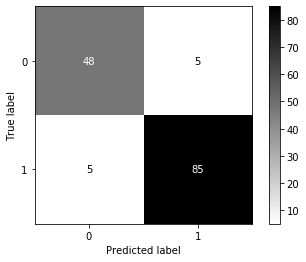

In [9]:
cancer_data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target,
                                                    stratify=cancer_data.target, random_state=0)
with warnings.catch_warnings(record=True) as w:
    lr = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(lr.score(X_test, y_test))
plot_confusion_matrix(lr, X_test, y_test, cmap='gray_r')

[[0.90566038 0.05555556]
 [0.09433962 0.94444444]]
0.9300699300699301


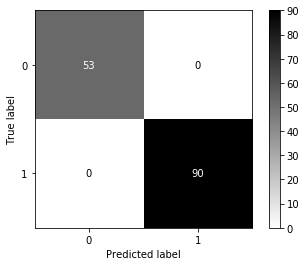

In [10]:
print(confusion_matrix(y_test, y_pred, normalize='pred'))
print(lr.score(X_test, y_test))
plot_confusion_matrix(lr, X_test, y_pred, cmap='gray_r')

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        53
           1       0.94      0.94      0.94        90

    accuracy                           0.93       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143



In [12]:
macro_avg_score = recall_score(y_test, y_pred, average='macro')
weight_avg_score = recall_score(y_test, y_pred, average='weighted')

In [13]:
print(macro_avg_score)

0.9250524109014675


In [14]:
print(weight_avg_score)

0.9300699300699301


### Loading the mammography dataset, which also happens to be pretty imbalanced

In [15]:
data = fetch_openml('mammography', as_frame=True)
X, y = data.data, data.target
X.shape

(11183, 6)

In [16]:
y.value_counts()

-1    10923
1       260
Name: class, dtype: int64

In [17]:
# make y boolean
# this allows sklearn to determine the positive class more easily
X_train, X_test, y_train, y_test = train_test_split(X, y == '1', random_state=0)

Trying out SVC and RandomForestClassifier

In [18]:
svc = make_pipeline(StandardScaler(),
                    SVC(C=100, gamma=0.1))
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.9864091559370529

In [19]:
y_pred = svc.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2732
        True       0.81      0.53      0.64        64

    accuracy                           0.99      2796
   macro avg       0.90      0.76      0.82      2796
weighted avg       0.98      0.99      0.99      2796



In [21]:
rf = make_pipeline(RandomForestClassifier())
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

0.9874821173104434
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2732
        True       0.89      0.52      0.65        64

    accuracy                           0.99      2796
   macro avg       0.94      0.76      0.82      2796
weighted avg       0.99      0.99      0.99      2796



Both precision and recall are higher for Random Forest => F1 score is higher

### Changing Thresholds
We can change the threshold fot predicting the classes. For example, we can say predict class 1 only when the probability of class 1 is greater than 40%. This allows us more freedom to tune the outcome based on our problem statement.

In [22]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2732
        True       0.89      0.52      0.65        64

    accuracy                           0.99      2796
   macro avg       0.94      0.76      0.82      2796
weighted avg       0.99      0.99      0.99      2796



Now changing threshold so that we get higher recall for the True class

In [23]:
y_pred = rf.predict_proba(X_test)[:, 1] > .30
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2732
        True       0.71      0.66      0.68        64

    accuracy                           0.99      2796
   macro avg       0.85      0.83      0.84      2796
weighted avg       0.99      0.99      0.99      2796



### Precision recall curve
Gives an idea of how precision varies with recall for given values of threshold.
The precision_recall_curve function returns a list of precision and recall values
for all possible thresholds (all values that appear in the decision function) in sorted
order. 

Each point along the curve  corresponds to a possible threshold of the
decision function.

For `plot_precison_recall_curve`, `decision_function` is specified under `response_method`. If `reasponse_method` is not specified in the method call, then by default `predict_proba` is tried first and if it is not available, then `decision_function` is used.


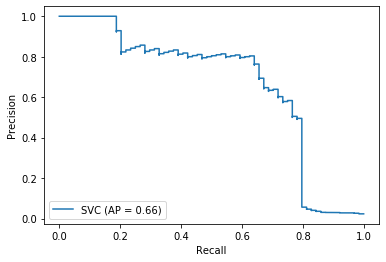

In [24]:
svc = make_pipeline(StandardScaler(),
                    SVC(C=10, gamma=0.1))
svc.fit(X_train, y_train)
plot_precision_recall_curve(svc, X_test, y_test, name='SVC')

The closer we are to the top right, the better the classifier, because that would mean a high precision and high recall for the same threshold. In this case, however, it looks like we get the best combination when recall is around 0.7 and precision is around 0.8.

Comparing the PR-curve of SVC with that of RandomForestClassifier

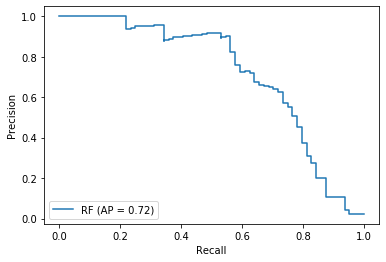

In [26]:
rf = make_pipeline(RandomForestClassifier())
rf.fit(X_train, y_train)
plot_precision_recall_curve(rf, X_test, y_test, name='RF')

Here we see that precision does not degrade that quickly with better recall.   
AP is Average Precision.

### Average precision 
$$ AP = \sum_{k=1}^n{P(k)\Delta r(k)} $$     
Here we are summing over data points ranked by decision function. $P(k)$ is the precision at threshold $k$. $\Delta r(k)$ denotes change in recall between $k$ and $k-1$   
Average precision is also the area under curve for the PR-curve.

In [37]:
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
print("Average precision for SVC = {:.3f}".format(ap_svc))
print("Average precision for RF = {:.3f}".format(ap_rf))

Average precision for SVC = 0.662
Average precision for RF = 0.717


### ROC curve
True Positive Rate (recall) vs False Positive Rate

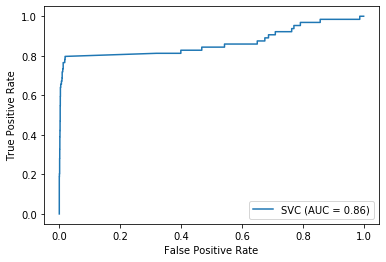

In [25]:
plot_roc_curve(svc, X_test, y_test, name='SVC')

PR-curve gives more weight to the positive class if the positive class is in minority.

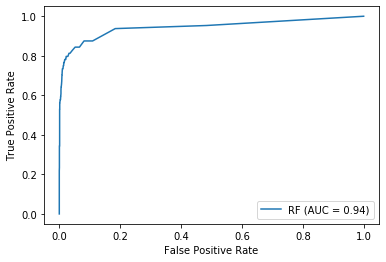

In [27]:
plot_roc_curve(rf, X_test, y_test, name='RF')

For the ROC curve, the ideal space is the top left - we want a classifier that produces  high recall while keeping a low false positive rate.

**Choosing the optimum threshold shouuld be done on the validation set.**

Interpolation is meaningful on ROC curve but not on PR-curve.

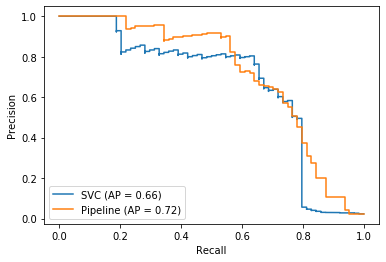

In [30]:
pr_svc = plot_precision_recall_curve(svc, X_test, y_test, name='SVC')
# if we used computed before, we could just call pr_svc.plot()
# using ax=plt.gca() will plot into the existing axes instead of creating  new ones
pr_rf = plot_precision_recall_curve(rf, X_test, y_test, ax=plt.gca())

Looking at the PR-curve and ROC-curve gives us a better picture of the performance of these classifiers for different threshold values. Just looking at F1 scores would not help us visualize the performance comprehensively

### Area under ROC curve
Always returns a value between 0 and 1

In [42]:
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.944
AUC for SVC: 0.865


Predicting randomly always produces an AUC of 0.5, no matter how imbalanced the dataset is. This makes it a better metric than accuracy. The AUC can be interpreted as
evaluating the ranking of positive samples. It’s equivalent to the probability that a randomly
picked point of the positive class will have a higher score according to the classifier
than a randomly picked point from the negative class. So, a perfect AUC of 1
means that all positive points have a higher score than all negative points.

**F1 score uses only the default threshold.**

## Multiclass classification

Accuracy: 0.951


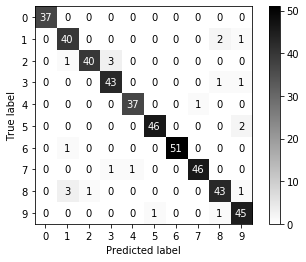

In [50]:
digits = load_digits()
 # data is between 0 and 16
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
with warnings.catch_warnings(record=True) as w:
    lr = LogisticRegression().fit(X_train, y_train)
    pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
plot_confusion_matrix(lr, X_test, y_test, cmap='gray_r')

In [51]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.93      0.91        43
           2       0.98      0.91      0.94        44
           3       0.91      0.96      0.93        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       1.00      0.98      0.99        52
           7       0.98      0.96      0.97        48
           8       0.91      0.90      0.91        48
           9       0.90      0.96      0.93        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



False positive: For 0, false positive means that a number was classified as 0, when it was something else.   
False negative: For 0, false negative means that a number was classified as something other than 0, when it was actually 0.

#### Metrics for multiclass classification

Threshold based:
- Accuracy
- Precision, recall, F1 score (macro, weighted)

Ranking:   
One vs Rest AUC, One vs One AUC

#### Metrics for regression models
$R^2$, MSE, Mean Absolute Error, Median absolute error

#### Mean Absolute Percentage Error
$$ MAPE = \frac{100}{n} \sum_{1=1}^n \left|\frac{y - \hat{y}}{y}\right| $$

For each individual point, we divide the residual by the true value.   
Basically what we mean is, if a data point is large, we care less about how well we predict it.   
This is a very commonly used measure in forecasting. Be careful when to use it because sometimes it might be not super intuitive. In particular, if something is not defined, if anything is zero, and if something is very close to zero, you need to perfectly predict it otherwise, you have unbound error. So this is usually used for things that are greater than one.

### Prediction Plots
True vs Predicted

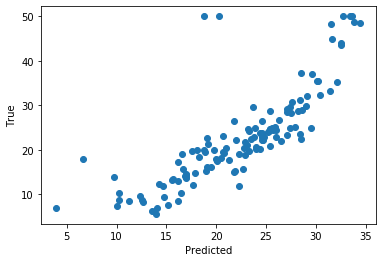

In [58]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)
ridge = Ridge(normalize=True)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
plt.plot(pred, y_test, 'o')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Residual vs Feature plots
Residual vs feature plots have the true feature values on the X-axis and the Y-axis is the residual: actual value - predicted value.
For each feature, this plot should be more or less a horizontal line, because the errors a model makes should be independent of the features. If that's not the case, then there is some aspect of the feature that the model failed to capture.

### List of scoring metrics

In [60]:
print("\n".join(sorted(SCORERS.keys())))

accuracy
adjusted_mutual_info_score
adjusted_rand_score
average_precision
balanced_accuracy
completeness_score
explained_variance
f1
f1_macro
f1_micro
f1_samples
f1_weighted
fowlkes_mallows_score
homogeneity_score
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted
max_error
mutual_info_score
neg_brier_score
neg_log_loss
neg_mean_absolute_error
neg_mean_gamma_deviance
neg_mean_poisson_deviance
neg_mean_squared_error
neg_mean_squared_log_error
neg_median_absolute_error
neg_root_mean_squared_error
normalized_mutual_info_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
r2
recall
recall_macro
recall_micro
recall_samples
recall_weighted
roc_auc
roc_auc_ovo
roc_auc_ovo_weighted
roc_auc_ovr
roc_auc_ovr_weighted
v_measure_score
